In [4]:
from tensorflow.keras.models import load_model
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.vae_model import vae_model
#from src.lstm_mapper_model import lstm_mapper_model
from src.util import (
    seq_data, 
    load_sim_data, 
    seq_data, 
    compute_perm_deviation, 
    calculate_perm_error, 
    select_random_instances,
    plot_boxplot,
    mesh_plot_comparisons,
    plot_mesh_permarray,
    load_exp_data,
    plot_mesh
)
from pyeit import mesh
from keras import backend as K
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
lstm_mapper = load_model("saved_model/lstm_best_2Dmapper_model.keras")

lstm_mapper.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 4, 30, 30, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 4, 1800)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4, 128)         │       230,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4, 224)         │        28,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4, 128)         │       180,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,054,714 (4.02 MB)

 Trainable params: 527,356 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 527,358 (2.01 MB)

## Load Data

In [7]:
n_el = 32
from pyeit import mesh
mesh_obj = mesh.create(n_el, h0=0.05)

In [8]:
voltage_sim, gamma_sim , _ = load_sim_data("data")
voltage = (voltage_sim - np.mean(voltage_sim, axis=0)) / np.std(voltage_sim, axis=0)
voltage = voltage.reshape(-1, 32, 32, 1)  
gamma = gamma_sim.reshape(-1, 2840, 1)

In [9]:
voltage_seq, gamma_seq = seq_data(voltage, gamma, n_seg=4)

print("New Shape of Voltages Data:")
print(voltage_seq.shape)
print("New Shape of Permittivity Data:")
print(gamma_seq.shape)

New Shape of Voltages Data:
(996, 4, 32, 32, 1)
New Shape of Permittivity Data:
(996, 2840, 1)


## Loading VAE Model and generating labels

In [10]:
vae = vae_model()  
vae.build(input_shape=(None, *gamma.shape[1:])) 
vae.load_weights("weights/vae2D_best_6000.weights.h5")
print("Gewichte erfolgreich geladen.")

_, _, latent_rep = vae.encoder.predict(gamma_seq)

Gewichte erfolgreich geladen.
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


## LSTM Mapper Training

In [11]:
(
    v_train_seq,
    v_test_seq,
    gamma_train,
    gamma_test,
    z_train,
    z_test,
) = train_test_split(
    voltage_seq,
    gamma_seq,
    latent_rep,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

In [12]:
history_mapper = lstm_mapper.fit(v_train_seq, z_train, epochs=50, validation_split = 0.2)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.2272 - mse: 1.2272 - val_loss: 0.2881 - val_mse: 0.2881
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2270 - mse: 0.2270 - val_loss: 0.2423 - val_mse: 0.2423
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1756 - mse: 0.1756 - val_loss: 0.2617 - val_mse: 0.2617
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2078 - mse: 0.2078 - val_loss: 0.2262 - val_mse: 0.2262
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1746 - mse: 0.1746 - val_loss: 0.3031 - val_mse: 0.3031
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1944 - mse: 0.1944 - val_loss: 0.2181 - val_mse: 0.2181
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1655 - mse: 0.1655 - val_loss: 0.2289 - val_mse: 0.2289
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1638 - mse: 0.1638 - val_loss: 0.1823 - val_mse: 0.1823
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.158

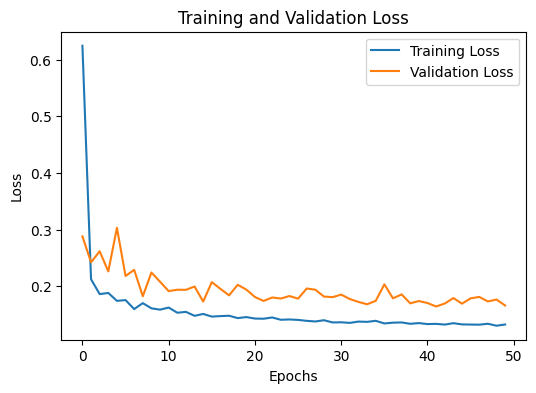

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(history_mapper.history["loss"], label="Training Loss")
plt.plot(history_mapper.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [16]:
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)
lstm_weights_file = os.path.join(weights_dir, "lstm_test1.weights.h5")
lstm_mapper.save_weights(lstm_weights_file)
print(f"Gewichte gespeichert unter: {lstm_weights_file}")

Gewichte gespeichert unter: weights/lstm_test1.weights.h5


In [17]:
lstm_mapper.load_weights(lstm_weights_file)
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [19]:
_, _, pred_latent = vae.encoder.predict(gamma_test)
gamma_pred = vae.decoder.predict(pred_latent).reshape(-1, 2840)

pred_latent.shape, v_test_seq.shape, gamma_pred.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


((100, 8), (100, 4, 32, 32, 1), (100, 2840))

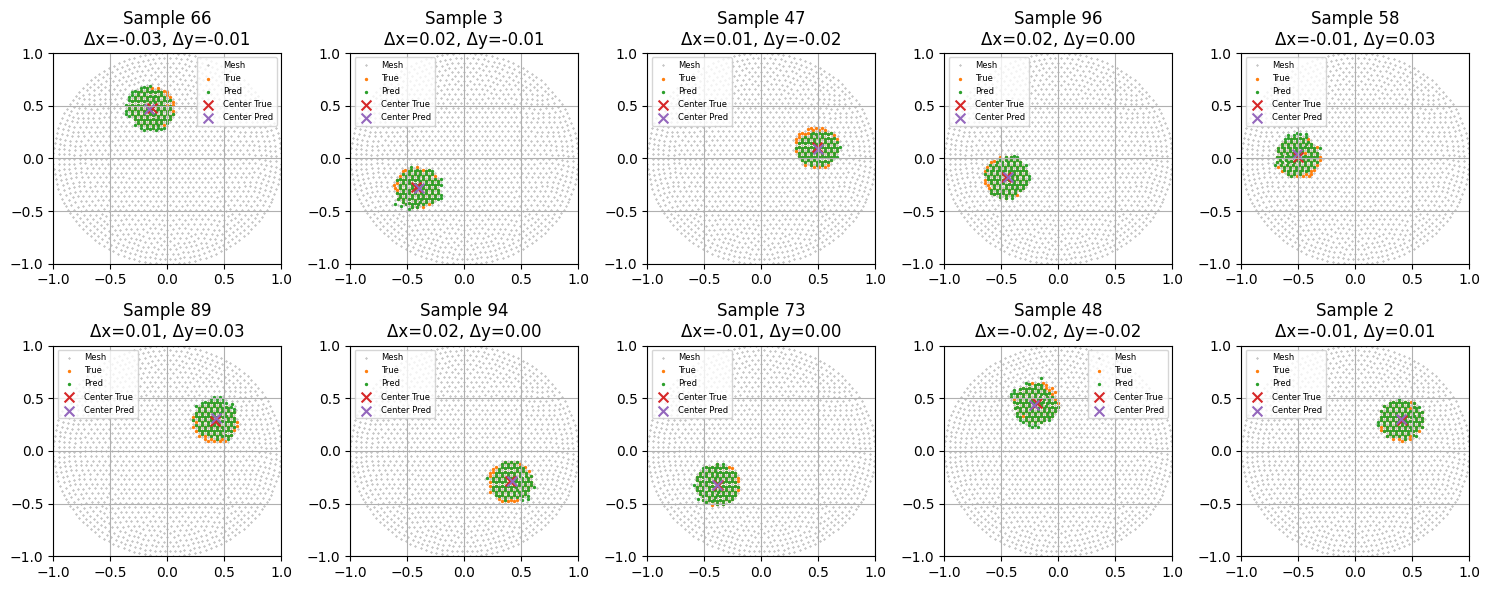

In [20]:
def compute_deviation(mesh_obj, true_perm, predicted_perm, threshhold=0.5):
    pts = mesh_obj.element
    tri = mesh_obj.node

    tri_centers = np.mean(tri[pts], axis=1)

    ixds_true = np.array(np.where(true_perm > threshhold)[0])
    koords_true = tri_centers[ixds_true]
    x_true = np.round(np.mean(koords_true[:, 0]), 2)
    y_true = np.round(np.mean(koords_true[:, 1]), 2)

    ixds_pred = np.array(np.where(predicted_perm > threshhold)[0])
    koords_pred = tri_centers[ixds_pred]
    x_pred = np.round(np.mean(koords_pred[:, 0]), 2)
    y_pred = np.round(np.mean(koords_pred[:, 1]), 2)

    deviation = (x_pred - x_true, y_pred - y_true)

    return deviation, (x_true, y_true), (x_pred, y_pred), koords_true, koords_pred

def plot_random_deviations(mesh_obj, true_perms, predicted_perms, num_samples=10, threshhold=0.5):
   
    random_indices = np.random.choice(len(true_perms), size=num_samples, replace=False)

    cols = 5
    rows = int(np.ceil(num_samples / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        ax = axes[i]
        true_perm = true_perms[idx]
        predicted_perm = predicted_perms[idx]

        _, (x_true, y_true), (x_pred, y_pred), koords_true, koords_pred = compute_deviation(
            mesh_obj, true_perm, predicted_perm, threshhold=threshhold
        )

        # Plot
        ax.grid()
        ax.set_xlim((-1, 1))
        ax.set_ylim((-1, 1))
        ax.scatter(mesh_obj.node[:, 0], mesh_obj.node[:, 1], color="grey", s=0.1, label="Mesh")
        ax.scatter(koords_true[:, 0], koords_true[:, 1], color="C1", s=2, label="True")
        ax.scatter(koords_pred[:, 0], koords_pred[:, 1], color="C2", s=2, label="Pred")
        ax.scatter(x_true, y_true, marker="x", color="C3", s=50, label="Center True")
        ax.scatter(x_pred, y_pred, marker="x", color="C4", s=50, label="Center Pred")
        ax.set_title(f"Sample {idx}\nΔx={x_pred-x_true:.2f}, Δy={y_pred-y_true:.2f}")
        ax.legend(fontsize=6)


    plt.tight_layout()
    plt.show()

plot_random_deviations(mesh_obj, gamma_test, gamma_pred, num_samples=10, threshhold=0.5)

In [47]:
voltage2_sim, gamma2_sim , _ = load_sim_data("data5")
voltage2 = voltage2_sim.reshape(-1, 32, 32, 1)  
gamma2 = gamma2_sim.reshape(-1, 2840, 1)
voltage4.shape

(1000, 32, 32, 1)

In [48]:
voltage2_seq, gamma2_seq = seq_data(voltage2, gamma2_sim, n_seg=4)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


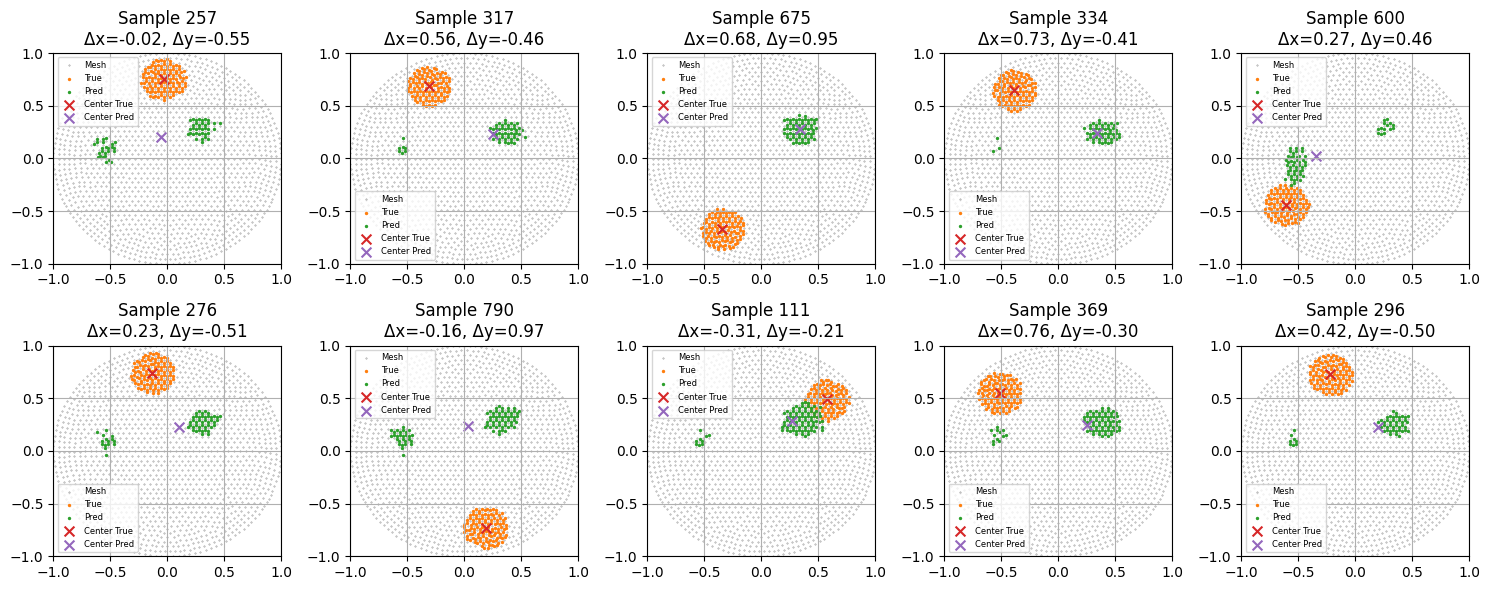

In [49]:
pred_latent = lstm_mapper.predict(voltage2_seq)
gamma_pred = vae.decoder.predict(pred_latent).reshape(-1, 2840)
plot_random_deviations(mesh_obj, gamma2, gamma_pred, num_samples=10, threshhold=0.5)